In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.sparse import coo_array
import pandas as pd

In [2]:
import CurvilinearFEM_Trial_2D as FEM

In [3]:
class custom_function_1d:
    def __init__(self, function, prime, prime2, inverse):
        assert function(0)==0, "Function must be zero at zero"
        assert function(1)==1, "Function must be one at one"
        assert prime(0)>=0, "Prime must be positive at zero"
        assert prime(1)>=0, "Prime must be positive at one"
        assert inverse(0)==0, "Inverse must be zero at zero"
        assert inverse(1)==1, "Inverse must be one at one"
        for i in np.linspace(0,1,100):
            assert (function(inverse(i))-i)**2<0.001, "The inverse is not correct"
        self.function = function
        self.prime = prime
        self.prime2 = prime2
        self.inverse = inverse

class custom_function_2d:
    def __init__(self, function, prime, inverse,name : str=""):
        for st in [(0,0),(0,1),(1,0),(1,1)]:
            f=function(st)
            inv=inverse(st)
            assert type(f) is np.ndarray, "Function must turn list."
            assert len(f) ==2, "Function must turn list of size 2."
            assert type(inv) is np.ndarray, "The inverse must turn tuple."
            assert len(inv) ==2, "The inverse must turn tuple of size 2."
            for i in range(2):
                assert f[i]==st[i], f"Function must be {st} at {st}, but it's turning {f}."
                assert inv[i]==st[i], f"The inverse must be {st} at {st}, but it's turning {inv}."
        for st in [(0,0),(0,1),(1,0),(1,1)]:
            p=prime(st)
            assert type(p) is np.ndarray, "The prime must turn 2x2 matrix (list of list)"
            assert len(p)==2, "The prime must turn 2x2 matrix (list of list)"
            assert len(p[0])==2, "The prime must turn 2x2 matrix (list of list)"
        for i in np.linspace(0,1,5):
            for j in np.linspace(0,1,5):
                f_inv=inverse(function((i,j)))
                assert (f_inv[0]-i)**2<0.001, "The inverse is not correct"
                assert (f_inv[1]-j)**2<0.001, "The inverse is not correct"
        
        self.function = function
        self.prime = prime
        self.inverse = inverse
        self.name = name

The code below solves 

$$\int v \, dxdy = \int v  \left( \nabla_{xy} \cdot \nabla_{xy} f \right) dxdy \\
\int v \, dxdy = - \int \left( \nabla_{xy} v \right)   \cdot \left( \nabla_{xy} f \right) dxdy \\
\int v \, | det(J^{xy}_{st})| \, dsdt  = - \int \left(J^{st}_{xy} \, \nabla_{st} v \right)^T \left(J^{st}_{xy} \, \nabla_{st} f \right) | det(J^{xy}_{st})| \, dsdt \\
\int \frac{v(s,t)}{ | det(J^{st}_{xy}(x,y))|}   \, dsdt  =
 - \int \frac{ \left( \nabla_{st} v(s,t) \right)^T  \, \left(J^{st}_{xy}(x,y)  \right)^T \, J^{st}_{xy}(x,y) \,\left(  \nabla_{st} f(s,t) \right) }{ | det(J^{st}_{xy}(x,y))|}   dsdt \\
\int \frac{v(s,t)}{ | det(J^{st}_{xy}(\alpha^{-1}(s,t)))|}   \, dsdt  =
 - \int \frac{ \left( \nabla_{st} v(s,t) \right)^T  \, \left(J^{st}_{xy}(\alpha^{-1}(s,t))  \right)^T \, J^{st}_{xy}(\alpha^{-1}(s,t)) \,\left(  \nabla_{st} f(s,t) \right) }{ | det(J^{st}_{xy}(\alpha^{-1}(s,t)))|}   dsdt \\
\int  \Sigma_k \frac{v(s_k,t) \, d_s(t)}{ | det(J^{st}_{xy}(\alpha^{-1}(s_k,t)))|}   \, dt  =
 - \int \Sigma_k \frac{ \left( \nabla_{st} v(s_k,t) \right)^T  \, \left(J^{st}_{xy}(\alpha^{-1}(s_k,t))  \right)^T \, J^{st}_{xy}(\alpha^{-1}(s_k,t)) \,\left(  \nabla_{st} f(s_k,t) \right) \, d_s(t) }{ | det(J^{st}_{xy}(\alpha^{-1}(s_k,t)))|}   dt \\
\Sigma_l  \Sigma_k \frac{v(s_k,t_l) \, d_s(t_l) d_t}{ | det(J^{st}_{xy}(\alpha^{-1}(s_k,t_l)))|}  =
 - \Sigma_l \Sigma_k \frac{ \left( \nabla_{st} v(s_k,t_l) \right)^T  \, \left(J^{st}_{xy}(\alpha^{-1}(s_k,t_l))  \right)^T \, J^{st}_{xy}(\alpha^{-1}(s_k,t_l)) \,\left(  \nabla_{st} f(s_k,t_l) \right) \, d_s(t_l) d_t}{ | det(J^{st}_{xy}(\alpha^{-1}(s_k,t_l)))|} \\
 $$ 

( recall $ dxdy = | det(J^{xy}_{st})| dsdt$, 
$ \nabla_{xy}=\begin{pmatrix}  \frac{\partial}{\partial x}  \\ \frac{\partial}{\partial y} \end{pmatrix} 
=J^{st}_{xy} \cdot \begin{pmatrix}  \frac{\partial}{\partial s}  \\ \frac{\partial}{\partial t} \end{pmatrix} ={J^{xy}_{st}}^{-1} \, \nabla_{st} $ 
, where $$J^{xy}_{st} =\begin{pmatrix}  \frac{\partial x}{\partial s} &  \frac{\partial y}{\partial s}  \\  \frac{\partial x}{\partial t} &  \frac{\partial y}{\partial t}  \end{pmatrix} $$, 

and $ dsdt = | det(J^{st}_{\zeta\eta})| d\zeta d\eta$, $\nabla_{st}=J^{\zeta \eta}_{st} \nabla_{\zeta \eta}$, 
where $$J^{st}_{\zeta \eta} 
= \begin{pmatrix}  \frac{\partial s}{\partial \zeta} &  \frac{\partial s}{\partial \eta}  \\  \frac{\partial t}{\partial \zeta} &  \frac{\partial t}{\partial \eta}  \end{pmatrix}
= \begin{pmatrix}  d &  0  \\  0 & d \end{pmatrix}, 
J^{\zeta \eta}_{st} 
= \begin{pmatrix}  \frac{\partial \zeta}{\partial s} &  \frac{\partial \zeta}{\partial t}  \\  \frac{\partial \eta}{\partial s} &  \frac{\partial \eta}{\partial t}  \end{pmatrix}
= \begin{pmatrix}  1/d &  0  \\  0 & 1/d \end{pmatrix}, $$)
 
the weak form of
$ 1 =  \nabla^2_{xy} f $
, where $ \begin{pmatrix}  s \\ t \end{pmatrix} = \alpha  \begin{pmatrix}  x \\ y \end{pmatrix} $ thus $J^{st}_{xy}= \begin{pmatrix}  \frac{\partial s}{\partial x} &  \frac{\partial t}{\partial x}  \\  \frac{\partial s}{\partial y} &  \frac{\partial t}{\partial y}  \end{pmatrix}$.
Note that here, we took the integral over the x domain, not t domain.  The gaussian summation is applied.


Define Trial funcion as the shape function at Node $i$, $v=N_i$.
$f=\Sigma_j \bar{u}_j N_j $

$$\Sigma_l  \Sigma_k \frac{N_i(s_k,t_l) \, d_s(t_l) d_t}{ | det(J^{st}_{xy}(\alpha^{-1}(s_k,t_l)))|}  =
 - \Sigma_j \bar{u}_j \left( \Sigma_l \Sigma_k \frac{ \left( \nabla_{st} N_i(s_k,t_l) \right)^T  \, \left(J^{st}_{xy}(\alpha^{-1}(s_k,t_l))  \right)^T \, J^{st}_{xy}(\alpha^{-1}(s_k,t_l)) \,\left(  \nabla_{st} N_j(s_k,t_l) \right) \, d_s(t_l) d_t}{ | det(J^{st}_{xy}(\alpha^{-1}(s_k,t_l)))|} \right) \\
$$

$$\eta \zeta$$

In [25]:
N_divisions:int = 5
N_nodes=(N_divisions+1)**2
f_analytical=lambda x,y: x**2+y**2

alpha=custom_function_2d(lambda xy:  np.array(xy),
                          lambda xy:  np.array([[1,0],[0,1]]), 
                          lambda st:  np.array( st), "identity")

alpha=custom_function_2d(lambda xy:  np.array([xy[0]**3,xy[1]**3]),
                          lambda xy:  np.array([[3*xy[0]**2,0],[0,3*xy[1]**2]]), 
                          lambda st:  np.array( [st[0]**(1/3),st[1]**(1/3)]), "cube")

alpha=custom_function_2d(lambda xy:  np.array([np.sqrt(xy[0]),xy[1]**3]),
                          lambda xy:  np.array([[0.5/np.sqrt(xy[0]),0],[0,3*xy[1]**2]]), 
                          lambda st:  np.array( [st[0]**2,st[1]**(1/3)]), "sqrt-cube")

# alpha=custom_function_2d(lambda xy:  np.array([np.sqrt(xy[0]**2+xy[1]**2),np.arctan2(xy[1],xy[0])*2/np.pi()]),
#                           lambda xy:  np.array([[0.5/np.sqrt(xy[0]),0],[0,3*xy[1]**2]]), 
#                           lambda st:  np.array( [st[0]**2,st[1]**(1/3)]))


alpha=custom_function_2d(lambda xy:  np.array([xy[0]**2,xy[1]**2]),
                          lambda xy:  np.array([[2*xy[0],0],[0,2*xy[1]]]), 
                          lambda st: np.sqrt(np.array( st)), "square")

# alpha=custom_function_2d(lambda xy:  np.sqrt(np.array(xy)),
#                           lambda xy:  np.array([[0.5/np.sqrt(xy[0]),0],[0,0.5/np.sqrt(xy[1])]]), 
#                           lambda st: np.array( st)**2)

d: float=1/N_divisions
# gaussian points to iterate over [0,1] 
# gauss_points = np.array([0.11270167, 0.5, 0.88729833])
# gauss_weights = np.array([5/9, 8/9, 5/9])*0.5
gauss_points = (np.array([-np.sqrt(5+2*np.sqrt(10/7))/3,-np.sqrt(5-2*np.sqrt(10/7))/3, 0, 
                              np.sqrt(5-2*np.sqrt(10/7))/3,np.sqrt(5+2*np.sqrt(10/7))/3])+1.0)*0.5
gauss_weights = np.array([(322-13*np.sqrt(70))/900, (322+13*np.sqrt(70))/900, 128/225, 
                          (322+13*np.sqrt(70))/900, (322-13*np.sqrt(70))/900])*0.5
N_gauss_points = gauss_points.size

# Shape functions : s,t\in[0,1]
N_nodes_e=4
N=lambda s,t: np.array([(1-s)*(1-t),  s*(1-t),(1-s)*t,  s*t])
N_derivatives=lambda s,t: np.array( [ [t-1,s-1],[1-t,-s],[-t,1-s],[t,s]])


K=np.zeros((N_nodes,N_nodes))
K_row=np.zeros(N_nodes)

f=np.zeros(N_nodes)
K_temp = np.zeros((N_nodes_e, N_nodes_e))
f_temp = np.zeros(N_nodes_e)
for i in range(N_divisions): # i-th division on s axis
    s=np.array([i*d,(i+1)*d])
    for j in range(N_divisions): # j-th division on t axis
        t=np.array([j*d,(j+1)*d])
        indeces=[j*(N_divisions+1)+i,
                 j*(N_divisions+1)+i+1,
                 (j+1)*(N_divisions+1)+i,
                 (j+1)*(N_divisions+1)+i+1]
        
        for k in range(N_gauss_points):# k-th gauss point over t
            t_temp=(j+gauss_points[k])*d
            for l in range(N_gauss_points):# l-th gauss point over s
                s_temp=(i+gauss_points[l])*d
                J_temp=alpha.prime(alpha.inverse([s_temp, t_temp]) )
                det_J_temp=np.abs(np.linalg.det(J_temp))
                JJ=J_temp.T@J_temp
                N_temp=N(gauss_points[l],gauss_points[k])
                N_derivatives_temp = N_derivatives(gauss_points[l],gauss_points[k])
                for m in range(N_nodes_e):
                    for n in range(N_nodes_e):
                        K_temp[m,n]=-N_derivatives_temp[m]@JJ@N_derivatives_temp[n]/4
                    f_temp[m]=N_temp[m]
                K_temp*=1/det_J_temp
                f_temp*=d*d/det_J_temp
                
                for m,index in enumerate(indeces):
                    for m2,index2 in enumerate(indeces):
                        K[index,index2] += K_temp[m,m2]*gauss_weights[k]*gauss_weights[l]
                    #K[index,indeces] += K_temp[m,:]*gauss_weights[k]*gauss_weights[l]
                
                for m,index in enumerate(indeces):
                    f[index] += f_temp[m]*gauss_weights[k]*gauss_weights[l]#*d*d*4##要：再調査
                #f[indeces] += f_temp*gauss_weights[k]*gauss_weights[l]

#Apply the Boundary condition.
BC_dict={}
for i in range(N_divisions+1):
    xy=alpha.inverse([i*d,0])
    BC_dict[i]=f_analytical(xy[0],xy[1])

    xy=alpha.inverse([0,i*d])
    BC_dict[i*(N_divisions+1)+0]=f_analytical(xy[0],xy[1])

    xy=alpha.inverse([1,i*d])
    BC_dict[(i+1)*(N_divisions+1)-1]=f_analytical(xy[0],xy[1])

    xy=alpha.inverse([i*d,1])
    BC_dict[i+N_divisions*(N_divisions+1)]=f_analytical(xy[0],xy[1])

no_BC_list=[i for i in range(N_nodes) if i not in BC_dict.keys() ]
A=np.zeros((len(no_BC_list),len(no_BC_list)))
b=np.zeros(len(no_BC_list))
for i,index_i in enumerate(no_BC_list):
    b[i]=f[index_i]
    for j,index_j in enumerate(no_BC_list):
        A[i,j]=K[index_i,index_j]
    for k,val in BC_dict.items():
        b[i]-=K[index_i,k]*val

A[0:5,0:5],b[0:5],K[0:5,0:5],f[0:5]

/var/folders/cn/yqnltnjd63l9dw00xky04wq40000gn/T/ipykernel_2288/1509772173.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  lambda xy:  np.array([[0.5/np.sqrt(xy[0]),0],[0,3*xy[1]**2]]),


(array([[-0.66077817,  0.14878175,  0.        ,  0.        ,  0.14878175],
        [ 0.14878175, -0.71448916,  0.22662401,  0.        ,  0.08365561],
        [ 0.        ,  0.22662401, -0.78616936,  0.28533373,  0.        ],
        [ 0.        ,  0.        ,  0.28533373, -0.85634117,  0.        ],
        [ 0.14878175,  0.08365561,  0.        ,  0.        , -0.71448916]]),
 array([-0.01874423, -0.0120009 , -0.02940649, -0.5788098 , -0.0120009 ]),
 array([[-0.30261534,  0.10671317,  0.        ,  0.        ,  0.        ],
        [ 0.10671317, -0.54458301,  0.2534958 ,  0.        ,  0.        ],
        [ 0.        ,  0.2534958 , -0.71373157,  0.34027846,  0.        ],
        [ 0.        ,  0.        ,  0.34027846, -0.84624439,  0.40895826],
        [ 0.        ,  0.        ,  0.        ,  0.40895826, -0.96033858]]),
 array([0.06894939, 0.06489197, 0.04221997, 0.03414265, 0.02947441]))

The RMSE is the Error in this case.
$$\text{RMSE} = \sqrt{\frac{1}{N_e} \sum_{e}^{} \int (f_e - \hat{f}_e)^2 dxdy}$$
To calculate it , we use gaussian numerical integration.


$$\int (f_e - \hat{f}_e)^2 dxdy \\
 = \int (f_e - \hat{f}_e)^2 dxdy \\
 = \Sigma_l  \Sigma_k \frac{\left(f_e(\alpha^{-1}(s,t)) - \Sigma_i \bar{u}_i \, N_i(s,t) \right)^{2} \, d_s(t_l) d_t}{ | det(J^{st}_{xy}(\alpha^{-1}(s_k,t_l)))|}  $$

In [26]:
x=np.linalg.solve(A,b)
x_numerical=np.zeros(N_nodes)
for i,index in enumerate(no_BC_list):
    x_numerical[index]=x[i]
for k,val in BC_dict.items():
    x_numerical[k]=val
t_vals=[ (i,j)  for j in np.linspace(0,1,N_divisions+1) for i in np.linspace(0,1,N_divisions+1)]
x_vals=[alpha.inverse(t_val) for t_val in t_vals]
x_analytical=np.array([f_analytical(a[0],a[1]) for a in x_vals])


In [27]:
for i in range(100):
    if i>=N_nodes:
        break
    print(t_vals[i],x_vals[i])

(0.0, 0.0) [0. 0.]
(0.2, 0.0) [0.4472136 0.       ]
(0.4, 0.0) [0.63245553 0.        ]
(0.6000000000000001, 0.0) [0.77459667 0.        ]
(0.8, 0.0) [0.89442719 0.        ]
(1.0, 0.0) [1. 0.]
(0.0, 0.2) [0.        0.4472136]
(0.2, 0.2) [0.4472136 0.4472136]
(0.4, 0.2) [0.63245553 0.4472136 ]
(0.6000000000000001, 0.2) [0.77459667 0.4472136 ]
(0.8, 0.2) [0.89442719 0.4472136 ]
(1.0, 0.2) [1.        0.4472136]
(0.0, 0.4) [0.         0.63245553]
(0.2, 0.4) [0.4472136  0.63245553]
(0.4, 0.4) [0.63245553 0.63245553]
(0.6000000000000001, 0.4) [0.77459667 0.63245553]
(0.8, 0.4) [0.89442719 0.63245553]
(1.0, 0.4) [1.         0.63245553]
(0.0, 0.6000000000000001) [0.         0.77459667]
(0.2, 0.6000000000000001) [0.4472136  0.77459667]
(0.4, 0.6000000000000001) [0.63245553 0.77459667]
(0.6000000000000001, 0.6000000000000001) [0.77459667 0.77459667]
(0.8, 0.6000000000000001) [0.89442719 0.77459667]
(1.0, 0.6000000000000001) [1.         0.77459667]
(0.0, 0.8) [0.         0.89442719]
(0.2, 0.8) [0.4

In [28]:
r=K@x_analytical-f
for i,index in enumerate(no_BC_list):
    if i >20:
        break
    print("%0.4f"%x_analytical[index], "%0.4f"%x_numerical[index], "%0.4f"%r[index])

0.4000 0.3997 -0.0001
0.6000 0.5998 -0.0000
0.8000 0.7999 -0.0000
1.0000 0.9999 -0.0000
0.6000 0.5998 -0.0000
0.8000 0.7999 -0.0000
1.0000 0.9999 -0.0000
1.2000 1.2000 -0.0000
0.8000 0.7999 -0.0000
1.0000 0.9999 -0.0000
1.2000 1.1999 -0.0000
1.4000 1.4000 -0.0000
1.0000 0.9999 -0.0000
1.2000 1.2000 -0.0000
1.4000 1.4000 -0.0000
1.6000 1.6000 -0.0000


In [29]:
((x_analytical-x_numerical)**2).sum(),x_analytical[0:5],x_numerical[0:5]

(2.2204777671629493e-07,
 array([0. , 0.2, 0.4, 0.6, 0.8]),
 array([0. , 0.2, 0.4, 0.6, 0.8]))

In [30]:
SE=0.0
sum=0.0

# 3 gaussian points to iterate over [0,1]
# x_numerical=np.zeros(N_nodes) # Integration validation (Done. SE=0)
for i in range(N_divisions): # i-th division on s axis
    s=np.array([i*d,(i+1)*d])
    for j in range(N_divisions): # j-th division on t axis
        t=np.array([j*d,(j+1)*d])
        indeces=[j*(N_divisions+1)+i,j*(N_divisions+1)+i+1,(j+1)*(N_divisions+1)+i,(j+1)*(N_divisions+1)+i+1]
        # xy=np.array([[alpha.inverse([s[k], t[l]])   for l in range(2)] for k in range(2)])
        SE_local=0.0
        for k in range(N_gauss_points):# k-th gauss point over t
            t_temp=(j+gauss_points[k])*d
            for l in range(N_gauss_points):# l-th gauss point over s
                s_temp=(i+gauss_points[l])*d
                
                xy=alpha.inverse([s_temp, t_temp])
                J_temp=alpha.prime(xy)
                #print(f"{J_temp=}")
                det_J_temp=np.abs(np.linalg.det(J_temp))
                #print(f'{det_J_temp=}')
                N_temp=N(gauss_points[l],gauss_points[k])
                #print(xy)
                error_temp=f_analytical(xy[0],xy[1])
                for m in range(N_nodes_e):
                    #continue
                    error_temp-=x_numerical[indeces[m]]*N_temp[m]
                # print(N_temp.sum()) # ==1
                SE_local+=gauss_weights[k]*gauss_weights[l]*error_temp**2/det_J_temp*d*d
                #sum+=gauss_weights[k]*gauss_weights[l]*d*d/det_J_temp
        #print(sum)
        SE+=SE_local
        #print(SE)
RMSE=np.sqrt(SE/1.0)

print(f'{RMSE=:0.6f}')
print(f"When numerical=0.0, RMSE={np.sqrt(28/45):0.6f} ")
# print(f"{x_vals[0:5]=}\n  {x_vals[-6:-1]=}\n{x_numerical[0:5]=}\n  {x_numerical[-6:-1]=}")
# print(f"{f_analytical(x_vals[0:5])=}\n  {f_analytical(x_vals[-6:-1])=}\n{RMSE=:0.6f}")



RMSE=0.000078
When numerical=0.0, RMSE=0.788811 


In [31]:
with open("output.txt", "a") as file:
    # write the N, alpha.name, RMSE in csv format
    file.write(f"{N_nodes},{alpha.name},{RMSE:0.6f}\n")

In [32]:
#plot graph of x_vals - x_numerical vs f_analytical(x_vals)
plt.plot(x_vals,f_analytical(x_vals),label='Analytical')
plt.scatter(x_vals,f_analytical(x_vals),label='Analytical',marker='x')
plt.plot(x_vals,x_numerical,ls=":",label='Numerical')
plt.scatter(x_vals,x_numerical,label='Numerical',marker='x')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Integration over x domain: {RMSE=:0.8f}')
plt.legend()
plt.show()

TypeError: <lambda>() missing 1 required positional argument: 'y'

In [ ]:
for N_divisions in [5,10,20,30,40,50,60,80,100]:
    print("N_divisions=",N_divisions)
    print("square")
    FEM.main(N_divisions, "square")
    print("sqrt")
    FEM.main(N_divisions, "sqrt")
    print("identity")
    FEM.main(N_divisions, "identity")
    print("cube")
    FEM.main(N_divisions, "cube")
    print("sqrt-cube")
    FEM.main(N_divisions, "sqrt-cube")
    print("sin")
    FEM.main(N_divisions, "sin")


In [25]:
df=pd.read_csv("output.txt",header=None)
df.columns=["N_nodes","alpha","RMSE"]
df

,N_nodes,alpha,RMSE
0,36,identity,0.013984
1,36,square,0.000078
2,121,square,0.000050
3,441,square,0.000029
4,961,square,0.000021
...,...,...,...
64,2601,sin,0.044388
65,3721,sin,0.040060
66,6561,sin,0.034144
67,10201,sin,0.030211


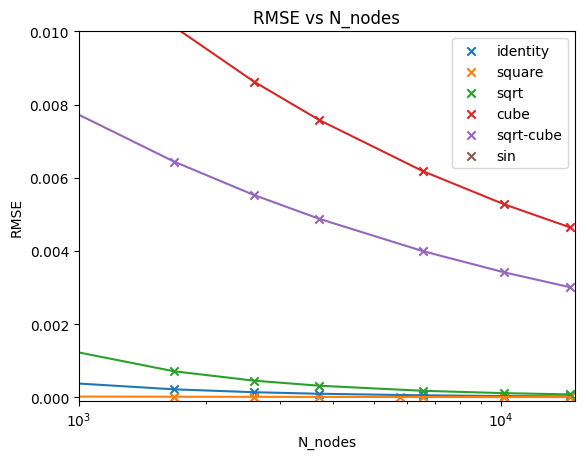

In [46]:
# Plot df, per alpha
# x: N_nodes(log), y: RMSE
for alpha in df.alpha.unique():
    df_alpha=df[df.alpha==alpha]
    # sort df alpha by N_nodes
    df_alpha=df_alpha.sort_values("N_nodes")
    plt.plot(df_alpha.N_nodes,df_alpha.RMSE)#
    plt.scatter(df_alpha.N_nodes,df_alpha.RMSE,label=alpha,marker='x')
plt.xlim(1000,15000)
#plt.ylim(-0.00001,0.001)
plt.ylim(-0.0001,0.01)
plt.xscale('log')
plt.xlabel('N_nodes')
plt.ylabel('RMSE')
plt.title('RMSE vs N_nodes')
plt.legend()
plt.show()


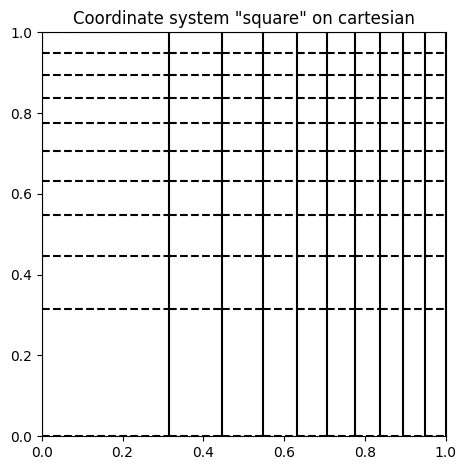

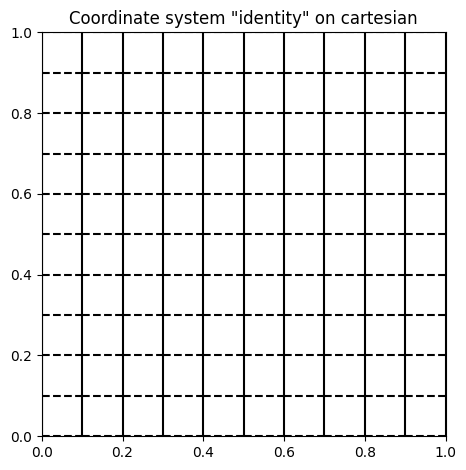

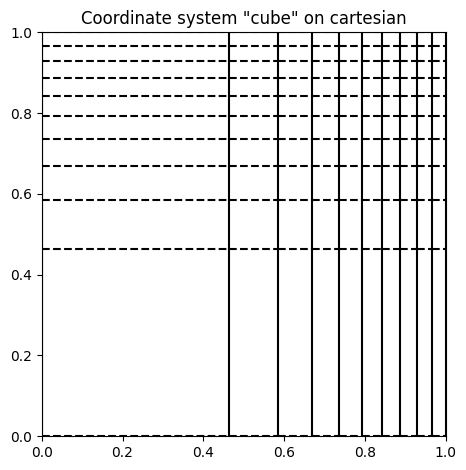

/Users/ina/Desktop/MasterResearch/CurvilinearFEM_Trial_2D.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  lambda xy:  np.array([[0.5/np.sqrt(xy[0]),0],[0,0.5/np.sqrt(xy[1])]]),


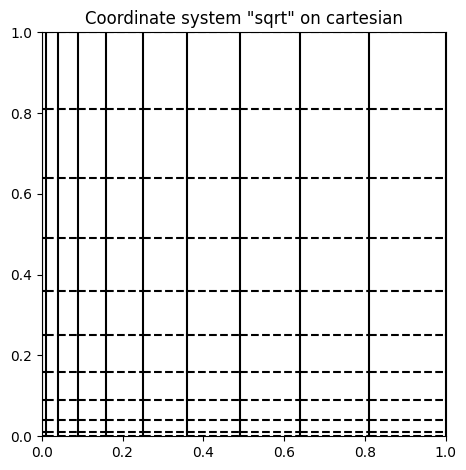

/Users/ina/Desktop/MasterResearch/CurvilinearFEM_Trial_2D.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  lambda xy:  np.array([[0.5/np.sqrt(xy[0]),0],[0,3*xy[1]**2]]),


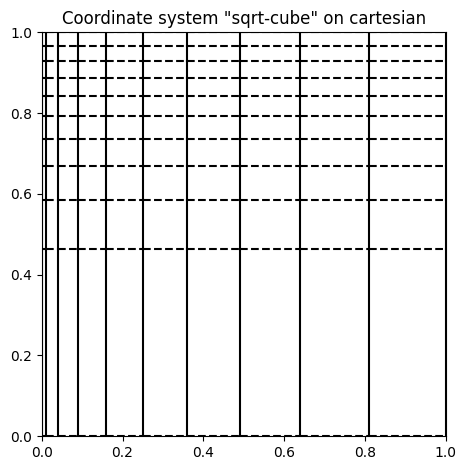

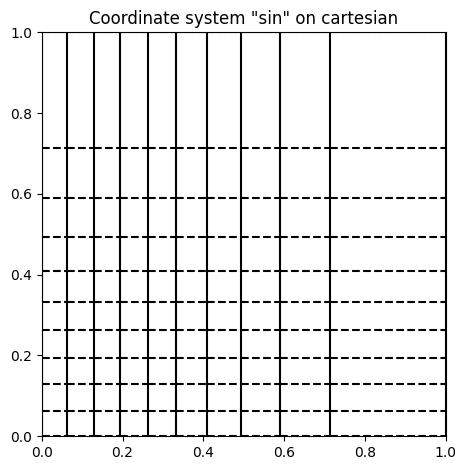

In [7]:
for name in ["square","identity","cube","sqrt","sqrt-cube","sin"]:
    alpha=FEM.generate_alpha(name)
    FEM.save_coor_shape_figure(alpha, 10)